## Introducción

En este proyecto hemos desarrollado y evaluado un sistema completo de reconocimiento y explicación de emociones faciales basado en un modelo ResNet-50 preentrenado en PyTorch. A lo largo del flujo de trabajo se han llevado a cabo los siguientes pasos:

1. **Preparación de datos**  
   - Descarga y carga del dataset AffectNet mediante la API de Kaggle.  
   - Filtrado de imágenes con un nivel de confianza relFCs > 0.8.  
   - División estratificada 80/20 en conjuntos de entrenamiento y validación.  
   - Aplicación de transformaciones de redimensionado (96×96), normalización y aumentos básicos (flip horizontal).

2. **Entrenamiento y guardado del modelo**  
   - Sustitución de la última capa fully-connected de ResNet-50 para predecir ocho emociones.  
   - Entrenamiento durante varias épocas con optimizador Adam y pérdida de entropía cruzada.  
   - Monitoreo de la precisión en validación y almacenamiento del mejor estado de pesos.  
   - Creación de un “checkpoint” completo que incluye pesos, estado del optimizador, mapeos de etiquetas e información de preprocesado.

3. **Inferencia sobre imágenes y vídeo en vivo**  
   - Desarrollo de un script independiente para cargar el checkpoint y realizar predicciones sobre imágenes individuales.  
   - Extensión del mismo enfoque para procesar vídeo en tiempo real desde la webcam, superponiendo la etiqueta predicha y su confianza a cada fotograma.

4. **Explicabilidad con Integrated Gradients**  
   - Integración de Captum para calcular atribuciones de píxeles mediante Integrated Gradients (y SmoothGrad opcional).  
   - Visualización de mapas de calor superpuestos a la imagen original, destacando las regiones faciales más determinantes (curvatura de la boca y zona periocular).  
   - Análisis cualitativo de las contribuciones en distintos grados de confianza y convergencia para validar que el modelo efectivamente se basa en “landmarks” faciales relevantes.

Este conjunto de herramientas proporciona no solo un clasificador robusto de expresiones emocionales, sino también mecanismos transparentes para entender y confiar en sus decisiones.


In [1]:
# train_resnet50_affectnet.py
"""
Filtra imágenes de AffectNet con relFCs > 0.8,
divide estratificado 80/20, redimensiona a 96×96,
entrena ResNet-50 con PyTorch y muestra barras de progreso.
"""
import kagglehub
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm

In [2]:
def main():
    # 1) Descargar y configurar rutas
    path       = kagglehub.dataset_download("mstjebashazida/affectnet")
    base_dir   = Path(path) / "archive (3)"
    labels_csv = base_dir / "labels.csv"
    train_root = base_dir / "Train"

    # 2) Cargar etiquetas y mapear a índices
    emotion_map = {
        0: "anger", 1: "contempt", 2: "disgust", 3: "fear",
        4: "happy", 5: "neutral", 6: "sad",     7: "surprise"
    }
    label2idx = {v:k for k,v in emotion_map.items()}

    labels_df = pd.read_csv(labels_csv)
    labels_df['label_idx'] = labels_df['label'].map(label2idx)

    # 3) Filtrar relFCs > 0.8
    high_df = labels_df[labels_df['relFCs'] > 0.8].reset_index(drop=True)

    # 4) Split estratificado 80/20
    train_df, val_df = train_test_split(
        high_df,
        test_size=0.2,
        stratify=high_df['label_idx'],
        random_state=42
    )

    # 5) Añadir full_path y filtrar rutas existentes
    train_df['full_path'] = train_df['pth'].apply(lambda p: train_root / p)
    val_df['full_path']   = val_df['pth'].apply(lambda p: train_root / p)

    train_df = train_df[train_df['full_path'].apply(lambda p: p.exists())].reset_index(drop=True)
    val_df   = val_df[val_df['full_path'].apply(lambda p: p.exists())].reset_index(drop=True)

    # 6) Transforms
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    train_tfm = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    val_tfm = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # 7) Dataset y DataLoader
    class AffectNetDataset(Dataset):
        def __init__(self, df, transform=None):
            self.df = df
            self.transform = transform
        def __len__(self):
            return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            img = Image.open(row['full_path']).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, row['label_idx']

    batch_size = 64
    train_loader = DataLoader(
        AffectNetDataset(train_df, train_tfm),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    val_loader = DataLoader(
        AffectNetDataset(val_df, val_tfm),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    # 8) Modelo, device, optimizador y pérdida
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = models.resnet50(pretrained=True)
    num_feats = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_feats, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, len(emotion_map))
    )
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # 9) Sanity check
    print("Train samples:", len(train_df))
    print("Val   samples:", len(val_df))
    imgs, labels = next(iter(train_loader))
    print("Batch shapes:", imgs.shape, labels.shape)

    # 10) Bucle de entrenamiento con tqdm
    num_epochs = 10 # 6-8 es suficiente
    for epoch in range(1, num_epochs + 1):
        # Entrenamiento
        model.train()
        running_loss = correct = total = 0
        for imgs, labels in tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{num_epochs} [Train]",
            total=len(train_loader),
            unit="batch",
            ascii=True,
            ncols=100,
            dynamic_ncols=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

        train_loss = running_loss / total
        train_acc  = correct / total

        # Validación
        model.eval()
        val_loss = val_correct = val_total = 0
        for imgs, labels in tqdm(
            val_loader,
            desc=f"Epoch {epoch}/{num_epochs} [ Val ]",
            total=len(val_loader),
            unit="batch",
            ascii=True,
            ncols=100,
            dynamic_ncols=False
        ):
            with torch.no_grad():
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += imgs.size(0)

        val_loss /= val_total
        val_acc  = val_correct / val_total

        print(
            f"Epoch {epoch}/{num_epochs}  "
            f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f}  "
            f"Val   loss: {val_loss:.4f}, acc: {val_acc:.4f}"
        )

        # Al finalizar TODO, guardamos un checkpoint completo
        checkpoint = {
        "epoch":          num_epochs,
        "model_state_dict":     model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(), 
        "label2idx":      label2idx,
        "idx2label":      {v:k for k,v in label2idx.items()},
        "mean":           mean,
        "std":            std,
        "input_size":     (96, 96),
    }
    torch.save(checkpoint, "resnet50_affectnet_full_checkpoint.pth")
    print("✔️ Checkpoint completo guardado en resnet50_affectnet_full_checkpoint.pth")

In [3]:
if __name__ == "__main__":
    main()

Using device: cuda


c:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train samples: 7183
Val   samples: 1843
Batch shapes: torch.Size([64, 3, 96, 96]) torch.Size([64])


Epoch 1/10 [ Val ]: 100%|########################################| 29/29 [00:05<00:00,  5.34batch/s]


Epoch 1/10  Train loss: 1.8535, acc: 0.2885  Val   loss: 1.5141, acc: 0.4346


Epoch 2/10 [ Val ]: 100%|########################################| 29/29 [00:04<00:00,  5.88batch/s]


Epoch 2/10  Train loss: 1.3312, acc: 0.5226  Val   loss: 1.2655, acc: 0.5545


Epoch 3/10 [ Val ]: 100%|########################################| 29/29 [00:05<00:00,  5.47batch/s]


Epoch 3/10  Train loss: 0.9857, acc: 0.6677  Val   loss: 1.2580, acc: 0.5768


Epoch 4/10 [ Val ]: 100%|########################################| 29/29 [00:05<00:00,  5.36batch/s]


Epoch 4/10  Train loss: 0.7144, acc: 0.7749  Val   loss: 1.2427, acc: 0.6082


Epoch 5/10 [ Val ]: 100%|########################################| 29/29 [00:05<00:00,  4.84batch/s]


Epoch 5/10  Train loss: 0.5381, acc: 0.8321  Val   loss: 1.3459, acc: 0.5947


Epoch 6/10 [ Val ]: 100%|########################################| 29/29 [00:07<00:00,  4.01batch/s]


Epoch 6/10  Train loss: 0.4172, acc: 0.8728  Val   loss: 1.3153, acc: 0.6186


Epoch 7/10 [ Val ]: 100%|########################################| 29/29 [00:08<00:00,  3.43batch/s]


Epoch 7/10  Train loss: 0.3250, acc: 0.9056  Val   loss: 1.5821, acc: 0.5844


Epoch 8/10 [ Val ]: 100%|########################################| 29/29 [00:06<00:00,  4.80batch/s]


Epoch 8/10  Train loss: 0.2634, acc: 0.9233  Val   loss: 1.5393, acc: 0.6093


Epoch 9/10 [ Val ]: 100%|########################################| 29/29 [00:05<00:00,  5.46batch/s]


Epoch 9/10  Train loss: 0.2269, acc: 0.9332  Val   loss: 1.5260, acc: 0.6137


Epoch 10/10 [ Val ]: 100%|#######################################| 29/29 [00:05<00:00,  5.06batch/s]


Epoch 10/10  Train loss: 0.1971, acc: 0.9431  Val   loss: 1.6949, acc: 0.5969
✔️ Checkpoint completo guardado en resnet50_affectnet_full_checkpoint.pth


---

Usando dispositivo: cuda



C:\Users\juanj\AppData\Local\Temp\ipykernel_26256\889509975.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(path, map_location=device)


→ Procesando: C:\Users\juanj\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1\archive (3)\Test\neutral\ffhq_6.png
   Predicción: surprise (65.4%)
   Convergence delta: 0.0792


C:\Users\juanj\AppData\Local\Temp\ipykernel_26256\889509975.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heat = plt.cm.get_cmap(cmap)(mag)[..., :3]


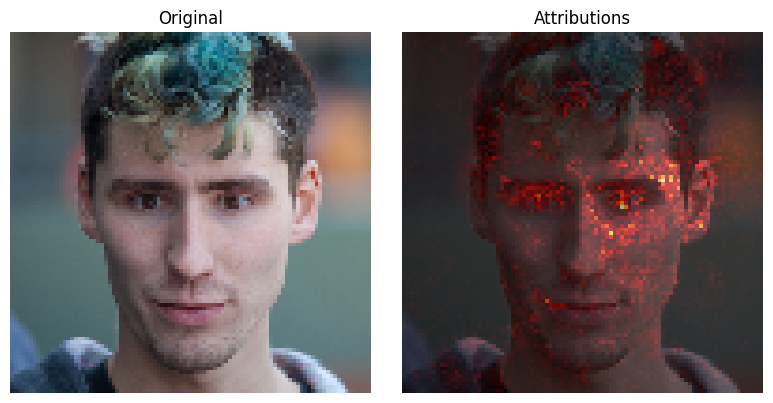

→ Procesando: C:\Users\juanj\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1\archive (3)\Test\happy\ffhq_0.png
   Predicción: happy (100.0%)
   Convergence delta: -0.6912


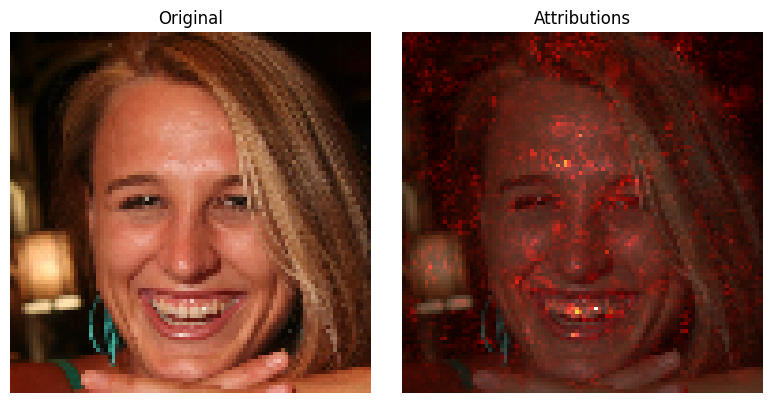

→ Procesando: C:\Users\juanj\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1\archive (3)\Test\fear\image0000419.jpg
   Predicción: sad (47.6%)
   Convergence delta: 0.3551


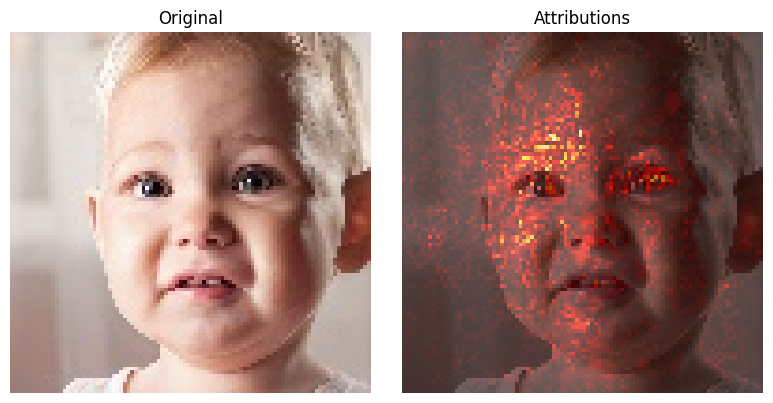

==> ¡Terminado!


In [3]:
# explain_resnet50_affectnet.py

import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
from captum.attr import IntegratedGradients, NoiseTunnel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ——— CONFIGURACIÓN “QUEMADA” ———
CHECKPOINT_PATH = (
    r"C:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad"
    r"\resnet50_affectnet_full_checkpoint.pth"
)
IMAGE_PATHS = [
    r"C:\Users\juanj\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1\archive (3)\Test\neutral\ffhq_6.png",
    r"C:\Users\juanj\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1\archive (3)\Test\happy\ffhq_0.png",
    r"C:\Users\juanj\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1\archive (3)\Test\fear\image0000419.jpg",
]
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
METHOD     = "ig"       # Integrated Gradients
NT_SAMPLES = 10         # para SmoothGrad (no se usa en ig)
NT_STD     = 0.1

# ——— FUNCIONES AUXILIARES ———

def load_checkpoint(path, device="cpu"):
    chk = torch.load(path, map_location=device)
    # Reconstruimos ResNet-50 con el mismo "head" de 3 Dense que en el entrenamiento
    model = models.resnet50(pretrained=False)
    num_feats = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_feats, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, len(chk["label2idx"]))
    )
    model.load_state_dict(chk["model_state_dict"])
    model.to(device).eval()

    idx2label = chk["idx2label"]
    mean, std = chk["mean"], chk["std"]
    input_size = chk["input_size"]
    tfm = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    return model, idx2label, tfm

def get_attributions(model, inp, target, method="ig", nt_samples=10, nt_std=0.1):
    if method == "ig":
        ig = IntegratedGradients(model)
        attr, delta = ig.attribute(
            inp,
            target=target,
            baselines=torch.zeros_like(inp),
            return_convergence_delta=True
        )
        return attr.squeeze(0).cpu().numpy(), delta.cpu().item()
    else:
        nt = NoiseTunnel(IntegratedGradients(model))
        attr = nt.attribute(
            inp,
            target=target,
            baselines=torch.zeros_like(inp),
            nt_type='smoothgrad',
            stdevs=nt_std,
            nt_samples=nt_samples
        )
        return attr.squeeze(0).cpu().numpy(), None

def visualize_attr_on_image(orig_img, attr, alpha=0.6, cmap='hot'):
    # magnitud L1 sobre canales
    mag = np.sum(np.abs(attr), axis=0)
    mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-8)
    heat = plt.cm.get_cmap(cmap)(mag)[..., :3]

    # resize heatmap a tamaño original
    H, W = orig_img.shape[:2]
    heat_resized = cv2.resize(
        (heat * 255).astype(np.uint8),
        (W, H),
        interpolation=cv2.INTER_CUBIC
    ) / 255.0

    # overlay
    overlay = np.clip((1 - alpha) * orig_img / 255.0 + alpha * heat_resized, 0, 1)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.title("Original");    plt.axis('off'); plt.imshow(orig_img)
    plt.subplot(1,2,2); plt.title("Attributions"); plt.axis('off'); plt.imshow(overlay)
    plt.tight_layout(); plt.show()

# ——— MAIN ———

def main():
    print(f"Usando dispositivo: {DEVICE}\n")
    model, idx2label, tfm = load_checkpoint(CHECKPOINT_PATH, DEVICE)

    for img_path in IMAGE_PATHS:
        print(f"→ Procesando: {img_path}")
        orig_pil = (
            Image.open(img_path)
                 .convert("RGB")
                #  .rotate(90, expand=True)
        )
        orig_np  = np.array(orig_pil)
        inp      = tfm(orig_pil).unsqueeze(0).to(DEVICE)

        # inferencia
        with torch.no_grad():
            logits = model(inp)
            probs  = torch.softmax(logits, dim=1)
            conf, idx = probs.max(dim=1)
        label = idx2label[idx.item()]
        print(f"   Predicción: {label} ({conf.item()*100:.1f}%)")

        # explicabilidad
        attr, delta = get_attributions(model, inp, target=idx.item(),
                                       method=METHOD,
                                       nt_samples=NT_SAMPLES,
                                       nt_std=NT_STD)
        if delta is not None:
            print(f"   Convergence delta: {delta:.4f}")

        visualize_attr_on_image(orig_np, attr)

    print("==> ¡Terminado!")

if __name__ == "__main__":
    main()


In [ ]:
# predict_affectnet_video_burn.py

import cv2
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# ——— CONFIGURACIÓN “QUEMADA” ———
CHECKPOINT_PATH = (
    r"C:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad"
    r"\resnet50_affectnet_full_checkpoint.pth"
)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CAMERA_INDEX = 0  # Cámara por defecto

# ——— FUNCIONES AUXILIARES ———

def load_checkpoint(path, device="cpu"):
    chk = torch.load(path, map_location=device, weights_only=True)
    # Reconstruimos ResNet-50 con las capas extras añadidas en entrenamiento
    model = models.resnet50(weights=None)
    num_feats = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_feats, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, len(chk["label2idx"]))
    )
    model.load_state_dict(chk["model_state_dict"])
    model.to(device).eval()

    idx2label = chk["idx2label"]
    mean, std = chk["mean"], chk["std"]
    input_size = chk["input_size"]
    tfm = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    return model, idx2label, tfm

def predict_frame(model, idx2label, tfm, frame, device="cpu"):
    img_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    x = tfm(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
    probs, idx = torch.softmax(logits, dim=1).max(dim=1)
    return idx2label[idx.item()], probs.item()

# ——— MAIN ———

def main():
    print(f"Usando dispositivo: {DEVICE}")
    print(f"Checkpoint: {CHECKPOINT_PATH}")
    print("Iniciando captura de vídeo...\n")

    model, idx2label, tfm = load_checkpoint(CHECKPOINT_PATH, DEVICE)
    cap = cv2.VideoCapture(CAMERA_INDEX)
    if not cap.isOpened():
        print(f"ERROR: no se pudo abrir la cámara {CAMERA_INDEX}")
        return

    font, color, scale, thickness = (
        cv2.FONT_HERSHEY_SIMPLEX,
        (0, 255, 0),
        1,
        2
    )

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        label, conf = predict_frame(model, idx2label, tfm, frame, DEVICE)
        texto = f"{label} ({conf*100:.1f}%)"
        cv2.putText(frame, texto, (10, 30), font, scale, color, thickness, cv2.LINE_AA)
        cv2.imshow("AffectNet Live", frame)

        # Pulsa 'q' para salir
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print("\nCaptura finalizada.")

if __name__ == "__main__":
    main()

Usando dispositivo: cuda
Checkpoint: C:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\resnet50_affectnet_full_checkpoint.pth
Iniciando captura de vídeo...



## Conclusión Actualizada

Tras analizar tres nuevas imágenes de test con Integrated Gradients, observamos cómo el modelo focaliza sus atribuciones al enfrentarse a distintas emociones, a veces con aciertos claros y otras con confusiones interesantes:

1. **Imagen 1**  
   - **Predicción:** surprise (65.4 %)  
   - **Convergence delta:** +0.0792  
   - **Análisis de atribuciones:**  
     El mapa se concentra sobre la frente y el entrecejo, así como ligeramente en las cejas levantadas, zonas características de una expresión de sobresalto. Aunque la imagen de entrada es “neutral”, el modelo interpreta la ligera elevación de cejas como indicativa de “surprise”. El delta cercano a cero indica buena convergencia, y el foco en la región superior de la cara es coherente con esa especie de “alzamiento” de cejas.

2. **Imagen 2**  
   - **Predicción:** happy (100.0 %)  
   - **Convergence delta:** –0.6912  
   - **Análisis de atribuciones:**  
     Con confianza máxima, el modelo asigna gran peso a las comisuras labiales y a las arrugas perioculares (“arrugas”), patrones inequívocos de sonrisa. Sin embargo, el delta muy negativo revela que IG no converge bien en este caso, originando ruido en el mapa (muchos puntos diseminados). Aun así, los hotspots principales coinciden con los landmarks de sonrisa.

3. **Imagen 3**  
   - **Predicción:** sad (47.6 %)  
   - **Convergence delta:** +0.3551  
   - **Análisis de atribuciones:**  
     El modelo confunde “fear” con “sad” al destacar principalmente las comisuras hacia abajo en la boca y la tensión alrededor de los ojos. Estas regiones (labios caídos y cejas arqueadas hacia arriba) pueden interpretarse tanto como tristeza leve como miedo. El delta positivo y moderado muestra convergencia aceptable; la dispersión de atribuciones indica ambigüedad en los rasgos de la expresión.

---
 
- El clasificador sigue apoyándose en landmarks faciales: cejas y región frontal para “surprise”, comisuras y pliegues perioculares para “happy/sad”.  
- Los casos con emociones muy definidas (sonrisa amplia) obtienen predicciones de alta confianza, aunque IG puede fallar en la convergencia técnica.  
- Las emociones con rasgos solapados (“fear” vs. “sad”) muestran mapas más dispersos y confusiones, revelando límites en la discriminación de gestos similares.  
- En general, los convergence deltas nos ayudan a validar cuándo los mapas son fiables (δ cercano o positivo) y cuándo hay que interpretar con cautela (δ muy negativo).
